# Fundamentos de Computação Gráfica
## Cassius Thalles C. Mendes

Neste trabalho implementaremos um algoritmo de aprendizado de máquina para o reconhecimento de imagens, mais precisamente dígitos numéricos escritos manualmente. Para tanto utilizaremos redes neurais convolucionais (Convolutional Neural Network ou simplesmente CNN). Embora seja possível implementar o algoritmo totalmente no python, eu optei por utilizar a biblioteca tensorflow pois esta é baseada em C/C++ e a execução do algorítmo é mais rápida do que uma implementação usando apenas python. Um outro benefício é que a biblioteca tensorflow permite o download do dataset MNIST que é o dataset usado neste trabalho. Por fim, esta biblioteca também permite lidar com a matemática, com maior ênfase na álgebra linear, de maneira mais prática.

Para começar o trabalho vamos importar os pacotes necessários.

In [2]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import matplotlib.pyplot as plt
%matplotlib inline

Como mencionei inicialmente, iremos aplicar o algoritmo ao dataset MNIST. Vamos então fazer o download do dataset usando o tensorflow.

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
dados = input_data.read_data_sets('data/MNIST/', one_hot=True)

#o parâmetro 'one_hot=True' fará com que o número representado na imagem passe a ser representado como um vetor de 10 
#dimensões, onde todas as entradas terão valor 0 exceto aquela que representa o número. Por exemplo:
#7 = [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
#0 = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
#2 = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [4]:
#Vejamos o tamanho dos dados que temos no dataset
print("Tamanho dos dados:")
print("- Dados de treino:\t\t{}".format(len(dados.train.labels)))
print("- Dados de teste:\t\t{}".format(len(dados.test.labels)))
print("- Dados de validação:\t\t{}".format(len(dados.validation.labels)))

Tamanho dos dados:
- Dados de treino:		55000
- Dados de teste:		10000
- Dados de validação:		5000


Os valores acima querem dizer que temos um total de 55000 dígitos diferentes nos dados de treino, 10000 nos dados de teste e 5000 nos dados de validação. Neste trabalho vamos focar apenas nos dados de treino e nos dados de teste.

Em posse dos dados podemos começar a implementar nosso algoritmo. Como mencionamos acima o 'one_hot' transforma um número em um vetor, mas também vamos precisar dos dados de teste representados como números, de preferência através de uma variável separada do conjunto de dados.

In [5]:
#classe dos dados de teste
dados.test.cls = np.argmax(dados.test.labels, axis=1)
print(dados.test.cls[0:5])
print(" ")
print(dados.test.labels[0:5, :])

[7 2 1 0 4]
 
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


Os dados que obtivemos tem características específicas que serão utilizadas durante o algoritmo, aqui vamos definir variáveis para armazenar cada uma dessas características.

In [6]:
tam_img = 28 #As imagens do dataset possuem dimensões 28x28 píxels
tam_img_flat = tam_img * tam_img #a representação da imagem em um vetor terá dimensão 28x28
forma_img = (tam_img, tam_img) #em certas ocasiões é necessário representar a imagem como um vetor, outras é melhor como tupla
num_canais = 1 #O número de canais de cor que utilizaremos, vamos deixar apenas 1 canal que representa escalas de cinza
num_classes = 10 #quantos dígitos possíveis nós temos, são as classes que representam os dados de saída

In [7]:
#função auxiliar para plotar imagens dos dígitos
    
def plot_images(images, cls_true, cls_pred=None):
    #o parâmetro imagens representa a imagem do dataset a ser utilizada para plotar
    #cls_true é a classificação correta da imagem
    #cls_pred é a predição da classificação da imagem, como padrão mantive como None para que possa ser utilizado para 
    #plotar imagens sem aplicar o algoritmo
    assert len(images) == len(cls_true) == 9 #vamos representar a imagem como uma grade 3x3
    
    #criando a figura como uma grade 3x3
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        #plotando a imagem
        ax.imshow(images[i].reshape(forma_img), cmap='binary')

        #criando legendas, caso necessário, para cls_verd e cls_pred
        if cls_pred is None:
            xlabel = "Verd: {0}".format(cls_true[i])
        else:
            xlabel = "Verd: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        #exibindo a legenda
        ax.set_xlabel(xlabel)
        
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

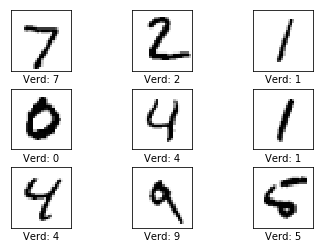

In [8]:
#Testando a função
imagens = dados.test.images[0:9] #pegando as 9 primeiras imagens dos dados de teste

cls_verd = dados.test.cls[0:9] #pegando as respectivas classificações

plot_images(imagens, cls_verd)

O nosso algoritmo de redes neurais convolucionais é baseado em alguns elementos primários, que compõem diretamente a rede, que é formada por duas camadas chamadas de input layer (que é a camada de entrada de dados) e output layer (a camada de saída de dados). Entre essas duas camadas existem outras camadas que são as convolutional layers (camadas convolucionais), ReLU (Rectified Linear Units - Unidades Lineares retificadas) e full_connected layers (camadas totalmente conectadas). Para gerar os inputs da full_connected layer, vamos usar uma camada de flatten layers (camadas achatadas). As camadas convolucionais são constituídas de neurônios, assim como no modelo linear os neurônios aqui dependem de pesos (weights) e viéses (biases) e de uma função de ativação $\sigma\left( z \right) = \dfrac{1}{1+ e^{-z}}$. 

In [9]:
#definindo uma função para gerar novos pesos (weights) e novos viéses (biases)
def new_weights(forma):
    #a linha abaixo vai gerar uma variável que será utilizada pelas funções do tensorflow, utilizei a classe Variable no
    #lugar de Tensor porque os valores atribuídos a Variable são persistentes fora de session.run.
    #A variável vai ser gerada através da função truncated_normal que pega um valor de uma distribuição normal com média
    #m = 0 e desvio padrão igual ao stddev (Standart Deviation - Desvio Padrão).
    #Esta variável vai ser representada através de uma variável que tem uma "forma" designada pelo parâmetro forma.
    return tf.Variable(tf.truncated_normal(forma, stddev=0.05))

def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

#definindo uma camada convolucional
def new_conv_layer(input, num_canais_input, tam_filtro, num_filtros, use_pooling=True):
    #input é a entrada de dados, que corresponde à saída de dados da camada anterior
    #num_canais_input é o número de canais de entrada
    #tam_filtro é o tamanho do filtro em altura e largura
    #num_filtros é a quantidade de filtros
    #use_pooling diz se está sendo utilizado o processo de pooling ou não
    
    forma = [tam_filtro, tam_filtro, num_canais_input, num_filtros]
    
    weights = new_weights(forma=forma)
    biases = new_biases(length=num_filtros)
    
    #aqui irei utilizar uma função do tensorflow que cria a operação para a convolução
    #stride possui 3 dimensões e vai ser mantido em 1 em elas
    #a primeira e a última dimensão do stride determinam respectivamente o número de imagens e o último é o número
    #de canais
    #as duas dimensões intermediárias representam respectivamente quanto o filtro se move no eixo x e no eixo y
    #o padding='SAME' preenche com zero os valores do filtro que ficariam vazios
    layer = tf.nn.conv2d(input=input, filter=weights, strides=[1,1,1,1], padding='SAME')
    
    #a linha acima quer dizer que os filtros são os pesos e que eles serão aplicados aos valores de entrada
    #abaixo vamos aplicar os viéses ao layer
    layer += biases
    
    #o processo de pooling simplifica a imagem e acaba por reduzir as dimensões da imagem, vamos usar aqui o processo
    #de pooling com uma janela 2x2 píxels
    if use_pooling:
        layer = tf.nn.max_pool(value=layer, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
        
    #ReLU
    #os valores negativos que aparecem são trocados por zero
    layer = tf.nn.relu(layer)
    
    return layer, weights

#definindo uma camada achatada
def flatten_layer(layer):
    #pegando a forma da camada recebida
    forma_camada = layer.get_shape()
    
    #vamos assumir aqui que a camada de entrada tem a forma [num-imagens, altura_img, largura_img, num_canais]
    
    #o número de características é dado pelo produto das dimensões 2, 3 e 4, no caso
    #altura_img * largura_img * num_canais
    #o tensorflow tem uma função para fazer esse cálculo
    num_features = forma_camada[1:4].num_elements()
    
    #agora vamos "achatar" a camada
    layer_flat = tf.reshape(layer, [-1, num_features])
    
    return layer_flat, num_features

#definindo uma camada totalmente conectada (full-connected layer)
def new_fc_layer(input, num_inputs, num_outputs, use_relu=True):
    #criando novos pesos e viéses
    weights = new_weights(forma=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)
    
    #aqui é um processo de multiplicação de matrizes e depois adição de matrizes,
    #vamos multiplicar uma matriz contendo os inputs com uma matriz contendo os pesos e depois adicionando uma
    #matriz contendo os viéses
    layer = tf.matmul(input, weights) + biases
    
    if use_relu:
        layer = tf.nn.relu(layer)
    
    return layer

Neste ponto do código vamos gerar algumas variáveis que serão responsáveis de receber valores que serão alterados a cada vez que o grafo da CNN for executado.

In [10]:
x = tf.placeholder(tf.float32, shape=[None, tam_img_flat], name='x')
#None no shape está dizendo que x vai receber inúmeros valores, cada um sendo um vetor cujo tamanho é tam_img_flat

x_image = tf.reshape(x, [-1, tam_img, tam_img, num_canais])

y_verd = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_verd')

y_verd_cls = tf.argmax(y_verd, axis=1)

Até agora nada foi calculado, apenas "preparamos o terreno". Agora vamos começar a montar nosso grafo CNN.

In [11]:
#Camada convolucional 1
filter_size1 = 5
num_filters1 = 16

#Camada convolucional 2
filter_size2 = 5
num_filters2 = 36

#Camada totalmente conectada
fc_size = 128

In [12]:
#criando a primeira camada
layer_conv1, weights_conv1 = new_conv_layer(x_image, num_canais, filter_size1, num_filters1, use_pooling=True)

#criando a segunda camada
layer_conv2, weights_conv2 = new_conv_layer(layer_conv1, num_filters1, filter_size2, num_filters2, use_pooling=True)

In [13]:
#criando a camada achatada
layer_flat, num_features = flatten_layer(layer_conv2)

In [14]:
#criando a camada totalmente conectada 1
layer_fc1 = new_fc_layer(layer_flat, num_features, fc_size, use_relu=True)

#criando a camada totalmente conectada 2
layer_fc2 = new_fc_layer(layer_fc1, fc_size, num_classes, use_relu=False)

Com isso temos nossa CNN criada, nossa CNN está composta por duas camadas convolucionais uma seguida da outra, uma flatten layer e, em seguida, duas camadas totalmente conectadas. A última camada gerará os outputs que nos dará a predição de qual número está representado na imagem de input. 

In [15]:
#y_pred está recebendo o output da camada totalmente conectada 2
y_pred = tf.nn.softmax(layer_fc2)

#o y_pred_cls está pegando o índice do maior valor em y_pred
y_pred_cls = tf.argmax(y_pred, axis=1)

O algoritmo necessita ser otimizado utilizando um algoritmo de otimização. Aqui utilizaremos o Adam optimization algorithms (Adam é derivado de Adaptative Moment Estimation) que é uma extensão do algoritmo Stochastic Gradient Descent. Ele é utilizado porque é fácil de implementar, é eficiente computacionalmente, requer pouca memória, é bom para problemas com grande quantidade de dados ou parâmetros e etc.

O algoritmo pode ser encontrado na internet, inclusive no artigo 'Adam: A Method for Stochastic Optimization'. 

Aqui utilizarei a função do tensorflow.

In [40]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2, labels=y_verd)
cost = tf.reduce_mean(cross_entropy)
otimizador = tf.train.AdamOptimizer(learning_rate=0.01).minimize(cost)

Agora vamos definir as medidas de performance acurácia (accuracy) e a predição correta (pred_certa).

In [17]:
pred_certa = tf.equal(y_pred_cls, y_verd_cls)
accuracy = tf.reduce_mean(tf.cast(pred_certa, tf.float32))

Agora vamos executar o algoritmo.

In [18]:
session = tf.Session()

In [19]:
session.run(tf.global_variables_initializer()) #inicializando pesos e viéses

In [20]:
train_batch_size = 64 #tamanho do lote de treinamento
#não utilizaremos todos os dados de uma única vez, mas utilizaremos pacotes

In [21]:
#iniciando contagem de treinamentos efetuados
total_iterations = 0

def optimize(num_iterations):
    #atualiando a variável global
    global total_iterations
    
    #contagem do tempo que demorou o treinamento
    start_time = time.time()
    
    for i in range(total_iterations, total_iterations + num_iterations):
        
        #pegando um lote de treinamento
        x_batch, y_true_batch = dados.train.next_batch(train_batch_size)
        
        #colocando os lotes em um dicionário com as variáveis criadas no tensorflow
        feed_dict_train = {x: x_batch, y_verd: y_true_batch}
        
        session.run(otimizador, feed_dict=feed_dict_train)
        
        #imprimindo o status a cada 50 interações
        if i%50 == 0:
            #calculando a acurácia
            acc = session.run(accuracy, feed_dict=feed_dict_train)
            
            msg = "Iteração de otimização: {0:>6}, Acurácia do treinamento: {1:>6.1%}"
            print(msg.format(i+1, acc))
        
    total_iterations += num_iterations
        
    #finalizando a contagem do tempo
    end_time = time.time()
        
    time_dif = end_time - start_time
        
    print("Tempo gasto: "+str(timedelta(seconds=int(round(time_dif)))))

In [22]:
def plot_example_errors(cls_pred, correct):
    incorrect = (correct == False)
    
    images = dados.test.images[incorrect]
    
    cls_pred = cls_pred[incorrect]
    
    cls_true = dados.test.cls[incorrect]
    
    plot_images(images[0:9], cls_true[0:9], cls_pred[0:9])

In [23]:
def plot_confusion_matrix(cls_pred):
    cls_true = dados.test.cls
    cm = confusion_matrix(y_true=cls_true, y_pred=cls_pred)
    
    print(cm)
    
    plt.matshow(cm)
    
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Pred')
    plt.ylabel('Verd')
    
    plt.show()

In [24]:
test_batch_size = 256

def print_test_accuracy(show_example_errors=False, show_confusion_matrix=False):
    #número de imagens no conjunto de testes
    num_test = len(dados.test.images)
    
    #alocando uma array para as classes que foram preditas
    cls_pred = np.zeros(shape=num_test, dtype=np.int)
    
    i = 0
    
    while i < num_test:
        #j é o índice de finalização do próximo lote
        j = min(i + test_batch_size, num_test)
        
        #pegando as imagens do conjunto de testes do índice i até o índice j
        images = dados.test.images[i:j, :]
        
        #pegando as classificações associadas
        labels = dados.test.labels[i:j, :]
        
        feed_dict = {x:images, y_verd: labels}
        
        #calculando a previsão da classe usando o tensorflow
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)
        
        i = j
    
    cls_true = dados.test.cls
    
    correct = (cls_true == cls_pred)
    
    #calculando o número de imagens corretamente classificadas
    correct_sum = correct.sum()
    
    #classificando a acurácia
    acc = float(correct_sum) / num_test
    
    #imprimindo a acurácia
    msg = "Accuracy no conjunto de dados: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))
    
    #plotando os exemplos:
    if show_example_errors:
        print("Exemplos dos erros:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)
    
    #plotando a matriz de confusão
    if show_confusion_matrix:
        print("Matriz de confusão")
        plot_confusion_matrix(cls_pred=cls_pred)

In [25]:
#rodando o teste
print_test_accuracy()

Accuracy no conjunto de dados: 7.7% (769 / 10000)


Como vimos acima, sem nenhuma otimização, o reconhecimento dos dígitos tem uma acurácia baixa.
Vamos realizar a otimização e verificar como a acurácia melhora conforme o algoritmo é treinado.

In [26]:
optimize(100)

Iteração de otimização:      1, Acurácia do treinamento:  25.0%
Iteração de otimização:     51, Acurácia do treinamento:  71.9%
Tempo gasto: 0:00:12


Accuracy no conjunto de dados: 93.8% (9378 / 10000)
Exemplos dos erros:


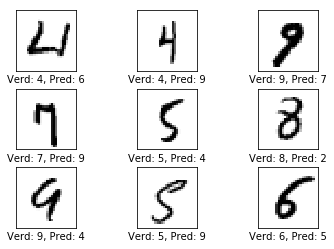

Matriz de confusão
[[ 923    0    7    3    1    6   14    1   12   13]
 [   0 1100    4    0    0    0    9    0   22    0]
 [   9    0  970   14    3    0    1   10   18    7]
 [   0    0   11  939    0   16    0   16   21    7]
 [   0    2    2    0  887    0   19   10    1   61]
 [   3    4    3    9    8  807    5    1   29   23]
 [  10    6    1    0   12    6  916    0    7    0]
 [   0    4   18   12    2    0    0  967    5   20]
 [   1    3    5    8    4    7    4    3  916   23]
 [   1    6    1    6   13    4    1   13   11  953]]


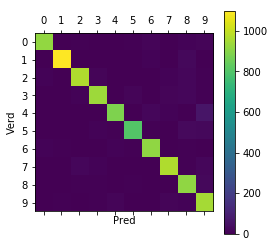

In [27]:
print_test_accuracy(True, True)

Com poucas iterações o algorítmo já se tornou bem eficaz. A matriz apresentada é representada utilizando cores logo abaixo. Esta matriz é lida da seguinte maneira: as colunas são as predições e as linhas são as classificações corretas.

Exemplo:
primeira coluna: 923 vezes o algoritmo clasdificou um zero como um zero, 0 vezes ele identificou o 1 como zero, 9 vezes identificou o 2 como 0, 0 vezes identificou o 3 como 0 e etc.

A imagem colorida representa a imagem utilizando cores como escala.

Vamos criar algumas funções para ver como o algoritmo definiu os pesos em cada filtro nas camadas e tentar entender como ele faz as alterações conforme o número de iterações de treinamentos são efetuadas.

In [28]:
def plot_conv_weights(weights, input_channel=0):
    #recebendo os pesos
    w = session.run(weights)
    
    #identificando os menores e os maiores valores de w
    w_min = np.min(w)
    w_max = np.max(w)
    
    #número de filtros utilizados na camada convolucional
    num_filters = w.shape[3]
    
    #número de grades a exibir
    num_grids = math.ceil(math.sqrt(num_filters))
    
    fig, axes = plt.subplots(num_grids, num_grids)
    
    #criando as figuras
    for i, ax in enumerate(axes.flat):
        if i < num_filters:
            img = w[:, :, input_channel, i]
            
            #plotando a imagem
            ax.imshow(img, vmin=w_min, vmax=w_max, interpolation='nearest', cmap='seismic')
        
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

In [29]:
def plot_conv_layer(layer, image):
    feed_dict = {x: [image]}
    
    #calculando e guardando as saídas de dado da camada depois do input
    values = session.run(layer, feed_dict=feed_dict)
    
    #número de filtros na camada de convolução
    num_filters = values.shape[3]
    
    num_grids = math.ceil(math.sqrt(num_filters))
    
    fig, axes = plt.subplots(num_grids, num_grids)
    
    for i, ax in enumerate(axes.flat):
        if i < num_filters:
            img = values[0, :, :, i]
            
            ax.imshow(img, interpolation='nearest', cmap='binary')
            
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

In [30]:
#plotando imagens
def plot_image(image):
    plt.imshow(image.reshape(forma_img), interpolation='nearest', cmap='binary')
    plt.show()

Dado um input qualquer, digamos 36. Qual a imagem correspondente a essa entrada no conjunto de testes?

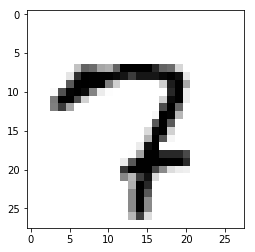

In [31]:
image1 = dados.test.images[36]
plot_image(image1)

A imagem corresponde a um número 7. Vejamos como a camada convolucional recebe essa imagem tanto na camada 1 como na camada 2 e visualizando os pesos.

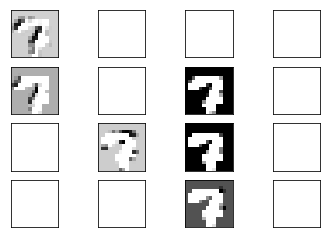

In [32]:
plot_conv_layer(layer_conv1, image1)

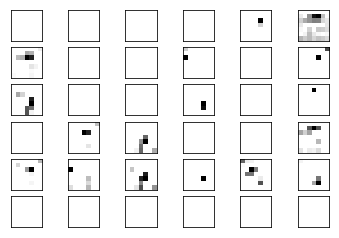

In [33]:
plot_conv_layer(layer_conv2, image1)

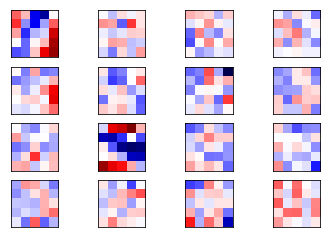

In [34]:
plot_conv_weights(weights_conv1)

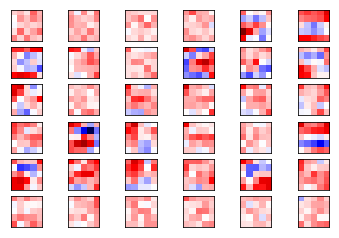

In [35]:
plot_conv_weights(weights_conv2)

Os pontos vermelhos são os pontos em que o neurônio reage positivamente, enquanto os azuis são os pontos em que o neurônio reage negativamente. Conforme podemos ver, com apenas 100 iterações de treinamento o algoritmo foi capaz de aumentar asustadoramente a acurácia, entretanto os pesos ainda estão um tanto irregulares. Podemos averiguar isso vendo as imagens do 7 nas camadas convolucionais. 

Vamos repetir o processo algumas vezes aumentando o número de iterações em cada tentativa e vamos analizar o que acontece.

Iteração de otimização:    101, Acurácia do treinamento:  92.2%
Iteração de otimização:    151, Acurácia do treinamento:  95.3%
Iteração de otimização:    201, Acurácia do treinamento:  98.4%
Iteração de otimização:    251, Acurácia do treinamento:  98.4%
Iteração de otimização:    301, Acurácia do treinamento:  98.4%
Iteração de otimização:    351, Acurácia do treinamento:  93.8%
Iteração de otimização:    401, Acurácia do treinamento:  98.4%
Iteração de otimização:    451, Acurácia do treinamento: 100.0%
Tempo gasto: 0:00:45
Accuracy no conjunto de dados: 97.3% (9730 / 10000)
Exemplos dos erros:


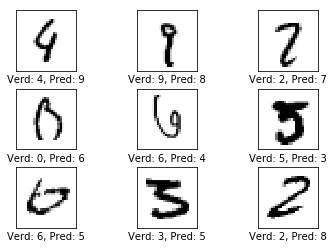

Matriz de confusão
[[ 941    0    2    0    0    3   27    1    4    2]
 [   0 1113    3    1    0    2    2    3   11    0]
 [   0    0 1000    2    3    0    0    7   20    0]
 [   0    0    3  979    0   14    0    7    7    0]
 [   0    0    1    0  966    1    1    4    1    8]
 [   0    0    1    5    0  877    5    0    4    0]
 [   2    5    0    0   13    2  933    0    3    0]
 [   0    1   11    1    0    0    0 1004    3    8]
 [   0    0    1    2    1    4   10    0  951    5]
 [   3    4    1    2    9   14    1    2    7  966]]


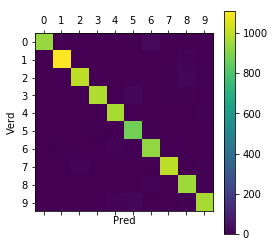

In [36]:
optimize(400)
print_test_accuracy(True, True)

Podemos ver que o número de erros diminuiu bastante. É interessante verificar que até agora fizemos apenas 500 iterações de treinamento e o algoritmo já teve uma boa otimização.

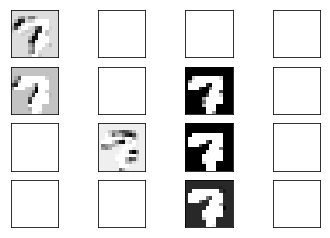

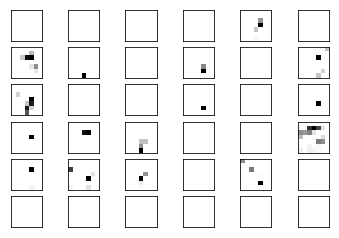

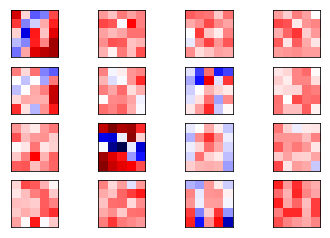

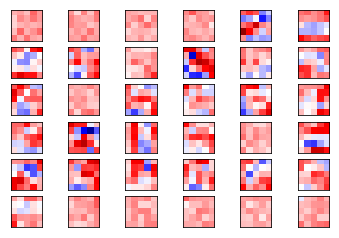

In [37]:
plot_conv_layer(layer_conv1, image1)
plot_conv_layer(layer_conv2, image1)
plot_conv_weights(weights_conv1)
plot_conv_weights(weights_conv2)

Embora a otimização tenha aumentado a acurácia, os pesos ainda estão irregulares. Agora na segunda camada basicamente todos os píxels causam uma reação positiva em maior ou menor grau nos neurônios. Não dá para interpretar adequadamente as camadas neurais onde as imagens do 7 aparecem.

Vamos aumentar o número de iterações para 9500 e vejamos o que ocorre.

Iteração de otimização:    501, Acurácia do treinamento: 100.0%
Iteração de otimização:    551, Acurácia do treinamento: 100.0%
Iteração de otimização:    601, Acurácia do treinamento: 100.0%
Iteração de otimização:    651, Acurácia do treinamento: 100.0%
Iteração de otimização:    701, Acurácia do treinamento: 100.0%
Iteração de otimização:    751, Acurácia do treinamento:  98.4%
Iteração de otimização:    801, Acurácia do treinamento:  98.4%
Iteração de otimização:    851, Acurácia do treinamento: 100.0%
Iteração de otimização:    901, Acurácia do treinamento:  98.4%
Iteração de otimização:    951, Acurácia do treinamento:  98.4%
Iteração de otimização:   1001, Acurácia do treinamento:  95.3%
Iteração de otimização:   1051, Acurácia do treinamento:  98.4%
Iteração de otimização:   1101, Acurácia do treinamento: 100.0%
Iteração de otimização:   1151, Acurácia do treinamento: 100.0%
Iteração de otimização:   1201, Acurácia do treinamento:  98.4%
Iteração de otimização:   1251, Acurácia

Iteração de otimização:   6951, Acurácia do treinamento:  98.4%
Iteração de otimização:   7001, Acurácia do treinamento:  98.4%
Iteração de otimização:   7051, Acurácia do treinamento:  98.4%
Iteração de otimização:   7101, Acurácia do treinamento: 100.0%
Iteração de otimização:   7151, Acurácia do treinamento: 100.0%
Iteração de otimização:   7201, Acurácia do treinamento: 100.0%
Iteração de otimização:   7251, Acurácia do treinamento:  98.4%
Iteração de otimização:   7301, Acurácia do treinamento: 100.0%
Iteração de otimização:   7351, Acurácia do treinamento:  98.4%
Iteração de otimização:   7401, Acurácia do treinamento: 100.0%
Iteração de otimização:   7451, Acurácia do treinamento: 100.0%
Iteração de otimização:   7501, Acurácia do treinamento:  98.4%
Iteração de otimização:   7551, Acurácia do treinamento: 100.0%
Iteração de otimização:   7601, Acurácia do treinamento:  98.4%
Iteração de otimização:   7651, Acurácia do treinamento:  98.4%
Iteração de otimização:   7701, Acurácia

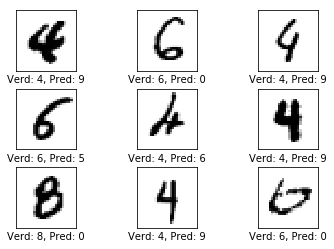

Matriz de confusão
[[ 975    0    0    0    0    1    1    1    1    1]
 [   0 1127    1    3    0    1    0    0    3    0]
 [   6    1 1012    2    1    0    0    4    5    1]
 [   1    1    1  996    0    4    0    2    3    2]
 [   1    8    0    0  934    0    3    2    4   30]
 [   1    2    0    7    0  876    2    1    2    1]
 [  11    7    0    0    2    6  930    0    2    0]
 [   0    4    5    0    0    0    0 1011    3    5]
 [   7    0    0    5    0    3    0    2  956    1]
 [   4    3    0    0    3    7    0    1    4  987]]


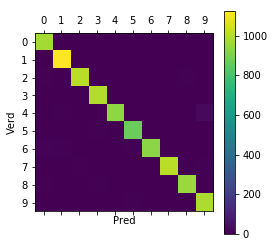

In [38]:
optimize(9500)
print_test_accuracy(True, True)

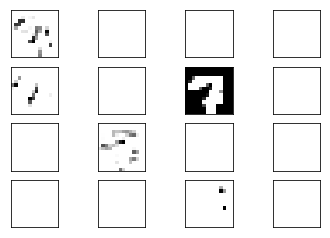

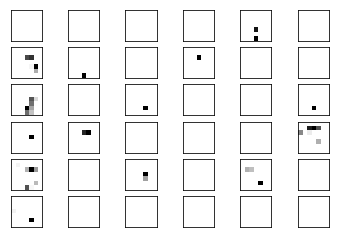

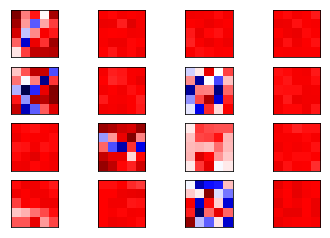

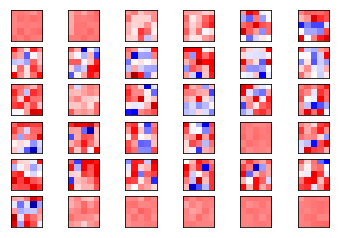

In [39]:
plot_conv_layer(layer_conv1, image1)
plot_conv_layer(layer_conv2, image1)
plot_conv_weights(weights_conv1)
plot_conv_weights(weights_conv2)

As duas últimas grades representam os pesos relacionados aos neurônios de cada camada, na camada de cima seria a imagemem cada neurônio.

O algoritmo após 10000 iterações de treinamento alcançou 98% de acurácia, um bom resultado. Entretanto é possível melhorar ainda mais a acurácia se continuar executando otimizações, entretanto vou finalizar por aqui.

Alguns fatos a se levar em consideração é que se diminuir o tamanho dos filtros das camadas convolucionais, por exemplo de 5 para 2, sem aumentar de maneira adequada o número de filtros, o algoritmo não se tornará eficaz na detecção dos dígitos. A inferência que eu faço é que isso seja causado pela perda de informação dos neurônios.

Por outro lado também não é interessante aumentar o tamanho dos filtros, aparentemente causa algum tipo de sobreposição das informações.

Com relação ao número de filtros, ocorre que se diminuir o número de filtros, a variação dos resultados tende a aumentar. Por exemplo, a acurácia chegar a 98% e depois cair para 80%, 76%. O resultado não se mostra consistente. Já aumentar o número de filtros faz com que o algoritmo se torne mais lento, entretanto há um crescimento mais gradual, porém mais consistente, da acurácia do algoritmo.

Atualmente o ReLU não é mais tão utilizado por ter pouca influência sobre os resultados, ao fazer os testes pude constatar essa afirmação, não houve mudança significativa do processo de aprendizagem do algoritmo. Então não é tão relevante utilizar o ReLU, mas como não notei também nenhuma diferença relevante no tempo de execução do algoritmo, acredito que usar ou não esse procedimento não tem impacto no processo.

Essas afirmações aqui feitas no final não são acompanhadas por uma nova execução do algoritmo pois para tanto deveria reiniciar o kernel do notebook e executar todo o algoritmo novamente. Apenas por este motivo não consta aqui a demonstração destes resultados.

### Referências
https://brohrer.github.io/how_convolutional_neural_networks_work.html

http://neuralnetworksanddeeplearning.com/index.html

https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/

https://www.youtube.com/playlist?list=PL9Hr9sNUjfsmEu1ZniY0XpHSzl5uihcXZ

http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/

http://deeplearning.net/tutorial/contents.html

https://arxiv.org/pdf/1412.6980.pdf